In [1]:
import sys
sys.path.append(".")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from tqdm.notebook import tqdm as tqdm
from Models import MultivariaLinearModel
from Datasets import CustomTensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
%reload_ext autoreload
%autoreload 2

# Pytorch' NN

## Linear regression with two variable 

In [3]:
data = np.loadtxt('ex1data2.txt', delimiter=',')
size, bedrooms, Y = data[:,0], data[:,1], data[:,2]
X = data[:,:2]


In [4]:
X.mean()

1001.9255319148937

In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

Datasets

In [6]:
train_ds = CustomTensorDataset(features=X_train, y=Y_train)
test_ds = CustomTensorDataset(features=X_test, y=Y_test)

In [7]:
for i in range(5):
    x, y = train_ds[i]
    print(f'X: {x}, Y: {y}')

X: tensor([ 1.0007, -0.1487], dtype=torch.float64), Y: tensor([299900.], dtype=torch.float64)
X: tensor([-1.5579, -1.5238], dtype=torch.float64), Y: tensor([179900.], dtype=torch.float64)
X: tensor([0.1449, 1.2264], dtype=torch.float64), Y: tensor([314900.], dtype=torch.float64)
X: tensor([0.9605, 1.2264], dtype=torch.float64), Y: tensor([499998.], dtype=torch.float64)
X: tensor([-1.0075, -0.1487], dtype=torch.float64), Y: tensor([199900.], dtype=torch.float64)


Dataloders

In [8]:
train_dl = DataLoader(train_ds, batch_size=len(train_ds))
test_dl = DataLoader(test_ds, batch_size=len(test_ds))

### Plotting de data

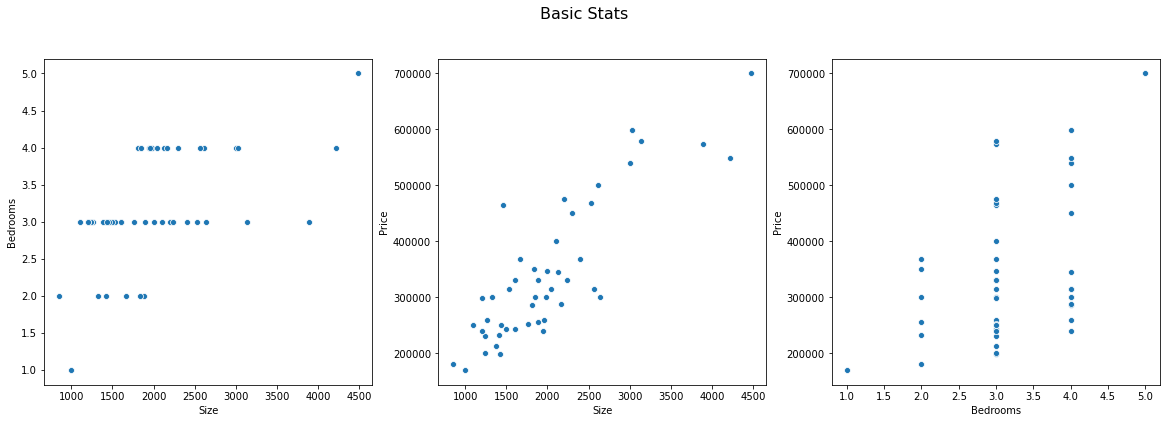

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Basic Stats', fontsize=16, y=1)

sns.scatterplot(x=size, y=bedrooms, ax=ax1)
ax1.set_xlabel('Size')
ax1.set_ylabel('Bedrooms')

sns.scatterplot(x=size, y=Y, ax=ax2)
ax2.set_xlabel('Size')
ax2.set_ylabel('Price')

sns.scatterplot(x=bedrooms, y=Y, ax=ax3)
ax3.set_xlabel('Bedrooms')
ax3.set_ylabel('Price')

plt.show()

### NN Model Class

In [10]:
torch.set_default_dtype(torch.double)

In [11]:
hidden_size = 6

### Training the net

In [13]:
model = MultivariaLinearModel(2, hidden_size, 1)
optimizer = optim.Adam(model.parameters(), lr=0.5)
maeloss_fn = nn.L1Loss(reduction='mean')
epochs=500

'''
# Esta configuracion funciona igualmente bien

model = MultivariaLinearModel(2, hidden_size, 1)
optimizer = optim.SGD(model.parameters(), lr=0.08)
maeloss_fn = nn.L1Loss(reduction='mean')
epochs=300
'''
model

MultivariaLinearModel(
  (layer): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=6, out_features=1, bias=True)
  )
)

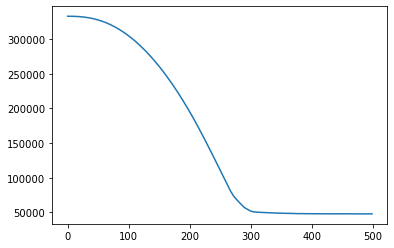

In [14]:
losses = model.fit(train_dl=train_dl, epochs=epochs, loss_fn=maeloss_fn, opt=optimizer)
plt.plot(range(epochs), losses)

In [15]:
min(losses), max(losses)

(47853.45500110934, 333127.07945435896)

In [16]:
x_train, y_train = train_ds.reverse_transform()

In [19]:
x_test, y_test = test_ds.reverse_transform()

### Validating the net

In [20]:
y_train_pred = model.predict(train_dl).numpy().squeeze()

In [21]:
y_test_pred = model.predict(test_dl).numpy().squeeze()

In [22]:
score_train = r2_score(y_train, y_train_pred)
print(f'Score in training: {score_train}')

Score in training: 0.6555198940476064


In [23]:
score_test = r2_score(y_test, y_test_pred)
print(f'Score in testing: {score_test}')

Score in testing: 0.7213830955385454


In [24]:
x_train, y_train = train_ds.reverse_transform()
x_test, y_test = test_ds.reverse_transform()

### Plotting results

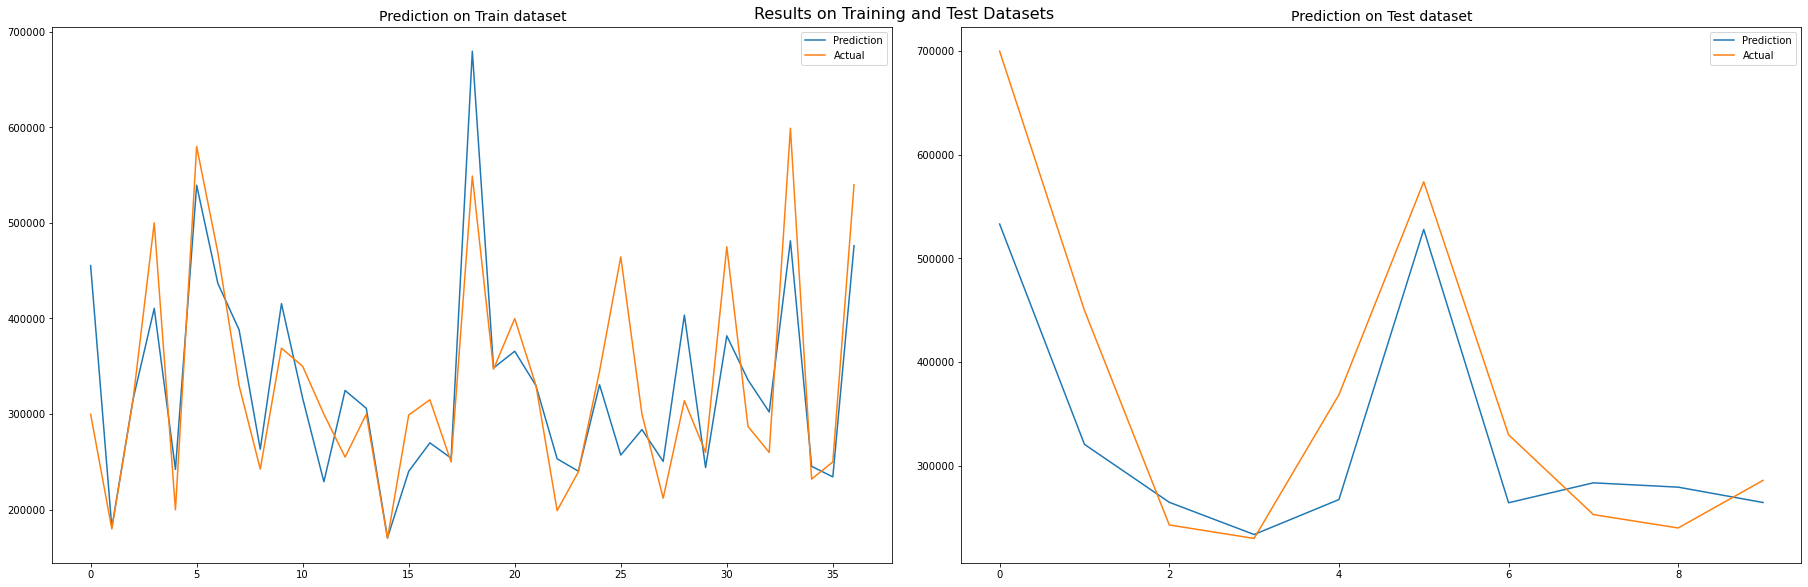

In [25]:
fig = plt.figure(constrained_layout=True, figsize=(25, 8))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax1 = fig.add_subplot(spec[0, 0])
ax2 = fig.add_subplot(spec[0, 1])

fig.suptitle('Results on Training and Test Datasets', fontsize=16, y=1)

sns.lineplot(y=y_train_pred, x=range(len(y_train_pred)), ax=ax1, label='Prediction')
sns.lineplot(y=y_train, x=range(len(y_train)), ax=ax1, label='Actual')
ax1.set_title('Prediction on Train dataset', fontsize=14)

sns.lineplot(y=y_test_pred, x=range(len(y_test_pred)), ax=ax2, label='Prediction')
sns.lineplot(y=y_test, x=range(len(y_test)), ax=ax2, label='Actual')
ax2.set_title('Prediction on Test dataset', fontsize=14)

plt.show()